In [84]:
import pyro
import pyro.distributions as dist
import torch
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import numpy as np
from torch.distributions import constraints

from pyro.poutine import trace
import graphviz

## model X and Y
### model X and Y with Betas from a normal distribution

In [79]:
lenX=10
betas =  pyro.sample("betas", dist.Normal(loc=0, scale=1).expand([lenX]))
ones = torch.ones(lenX)
betas1 = torch.stack((betas, ones), 1)
print(f'betas.shape {betas.shape}')
print(f'ones.shape {ones.shape}')
print(f'betas1.shape {betas1.shape}')



x_data = torch.randn(lenX)
y_data = 3 * x_data + 1 + torch.randn(lenX) * 0.5  # y = 3x + 1 + noise
A = torch.stack((x_data, ones), 1).transpose(0,1) #stack ones to the x_data for the bias term

mu_y = torch.matmul(A, betas)
print(f'mu_y.shape {mu_y.shape}')
print(f'y_data.shape {y_data.shape}')
print(f'A.shape {A.shape}')

betas.shape torch.Size([10])
ones.shape torch.Size([10])
betas1.shape torch.Size([10, 2])
mu_y.shape torch.Size([2])
y_data.shape torch.Size([10])
A.shape torch.Size([2, 10])


In [ ]:
## model X and Y with Betas from a normal distribution

$$
Y \sim N(\beta^{T} \cdot X, \sigma^{2})\\
\beta \sim N(0, \lambda^{2}) \\
where \\
\sigma = 1 \\
\lambda = 10\\
$$
$$X = {Gene Methyl}_{i} \\
Y = RNA_{Expr}
$$

$$
Y \sim N(\beta^{T} \cdot X, \sigma^{2})\\

Y \sim NB(\beta^{T} \cdot X, \sigma^{2})\\
\beta \sim Beta(\alpha, \beta) \\
where \\
\alpha , \alpha \sim ushaped methylation \\

$$
$$X = {Gene Methyl}_{i} \\
Y = RNA_{Expr}
$$

In [76]:
import pyro
import pyro.distributions as dist
import torch
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import numpy as np
from torch.distributions import constraints


# Define the linear model
def oneParam_LinReg_Normal(x_data, y_data):

    lenX=x_data.shape[0]

    # Define the priors on the X variables
    #beta for explanatory variable comes from nomal distribution
    betas =  pyro.sample("betas", dist.Normal(loc=0, scale=1).expand([lenX]))
    bias =  pyro.sample("bias", dist.Normal(loc=0, scale=1).expand([lenX]))
    ones = torch.ones(lenX)
    betas = torch.stack((betas, ones), 1)

    mu_y = torch.matmul(x_data, betas) #didn't work
    #mu_y = torch.matmul(x_data, betas) + bias

    sigma_y = pyro.sample("sigma", torch.tensor(10.),
                       constraint=constraints.positive)

    # Condition on the observed data
    with pyro.plate("sample", len(y_data)):
        Y = pyro.sample("Y", dist.Normal(loc=mu_y, scale=sigma_y), obs=y_data) #change this for other distributions

# #define guide function
# def guide(x_data, y_data):
#     lenX = x_data.shape[0]

#     # Priors for the guide parameters
#     betas_loc = pyro.param("betas_loc", torch.zeros(lenX))
#     betas_scale = pyro.param("betas_scale", torch.ones(lenX),
#                              constraint=constraints.positive)

#     # Sample betas and sigma from the guide distributions
#     pyro.sample("betas", dist.Normal(loc=betas_loc, scale=betas_scale))


# Generate some toy data data; 
x_data = torch.randn(100)
y_data = 3 * x_data + 1 + torch.randn(100) * 0.5  # y = 3x + 1 + noise
pyro.render_model(oneParam_LinReg_Normal, model_args=(x_data,y_data,), render_params=True, render_distributions=True)


# ###Run inference
# adam_params = {"lr":0.001}
# optimizer = Adam(adam_params)
# svi = SVI(model=oneParam_LinReg_Normal, guide=guide, optim=optimizer, loss=Trace_ELBO())
# # Inference loop
# num_iterations = 1000  # You can adjust this
# for j in range(num_iterations):
#     # Calculate the loss and take a gradient step
#     loss = svi.step(x_data, y_data)
#     if j % 100 == 0:
        # print(f"Epoch {j} : loss = {loss}")


TypeError: 'Tensor' object is not callable

In [43]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from torch.distributions import constraints

def oneParam_LinReg_Normal(x_data, y_data):
    lenX = x_data.shape[0]
    betas = pyro.sample("betas", dist.Normal(0, 1).expand([lenX]))
    mu_y = torch.matmul(x_data, betas)
    sigma_y = pyro.sample("sigma", dist.LogNormal(0, 1))  # Changed to pyro.sample

    with pyro.plate("sample", len(x_data)):
        Y = pyro.sample("Y", dist.Normal(mu_y, sigma_y), obs=y_data)

def guide(x_data, y_data):
    lenX = x_data.shape[0]
    betas_loc = pyro.param("betas_loc", torch.zeros(lenX))
    betas_scale = pyro.param("betas_scale", torch.ones(lenX), constraint=constraints.positive)
    sigma_loc = pyro.param("sigma_loc", torch.tensor(0.0))
    sigma_scale = pyro.param("sigma_scale", torch.tensor(1.0), constraint=constraints.positive)

    pyro.sample("betas", dist.Normal(betas_loc, betas_scale))
    pyro.sample("sigma", dist.LogNormal(sigma_loc, sigma_scale))

x_data = torch.randn(100, 1)  # Ensure correct shape
y_data = 3 * x_data + 1 + torch.randn(100, 1) * 0.5

adam_params = {"lr": 0.001}
optimizer = Adam(adam_params)
svi = SVI(oneParam_LinReg_Normal, guide, optimizer, loss=Trace_ELBO())

num_iterations = 1000
for j in range(num_iterations):
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print(f"Epoch {j} : loss = {loss}")


RuntimeError: size mismatch, got input (100), mat (100x1), vec (100)
Trace Shapes:      
 Param Sites:      
Sample Sites:      
   betas dist     |
        value 100 |

### model X and Y with Betas from a beta distribution

In [94]:
# Define the linear model
def oneParam_LinReg_betaPrior(x_data, y_data):
    # Define the priors on the X variables
    lenX=x_data.shape[0]

    #beta comes  from beta distribution
    ymax = torch.max(y_data)
    betas =  pyro.sample("betas", dist.Uniform(1, ymax).expand([lenX]))

    mu_y = torch.matmul(x_data, betas)  # Using PyTorch matmul
    sigma_y = pyro.param("sigma", torch.tensor(1.),
                       constraint=constraints.greater_than(1))

    # Condition on the observed data
    with pyro.plate("Genes", len(x_data)):
        Y = pyro.sample("Y", dist.Normal(mu_y, sigma_y), obs=y_data) #this is the link function
        #change this for other distributions


# Generate some data (replace with your actual data)
x_data = torch.randn(100)
y_data = 3 * x_data + 1 + torch.randn(100) * 0.5  # y = 3x + 1 + noise
ppp=pyro.render_model(oneParam_LinReg_betaPrior, model_args=(x_data,y_data,), render_params=True ,render_distributions=True) #why are hyperparams not showing
# Save the graph to a file
ppp.format = 'pdf'
ppp.render('/Users/ahunos/myWork/coursework/FoundationsOfDataScience_F23/finals/model_graph_oneParam_LinReg_betaPrior')


'/Users/ahunos/myWork/coursework/FoundationsOfDataScience_F23/finals/model_graph.pdf.pdf'

In [90]:
# Render the model
traced_model = trace(lambda: oneParam_LinReg_betaPrior(x_data, y_data)).get_trace()
graph = pyro.render_model(traced_model)

# Save the graph to a file
graph.format = 'png'
graph.render('model_graph')

TypeError: 'Trace' object is not callable

$$
Y \sim N(\beta^{T}.X, \sigma^{2})\\
\beta \sim Beta(\alpha, \beta)
$$

$$

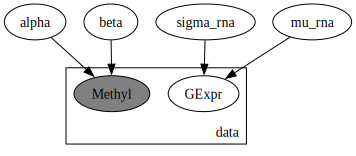

In [21]:


# Define the linear model
def linear_model(x_data, y_data=None):
    # Define the priors on the X variables
    alpha = pyro.sample("alpha", dist.Normal(0, 10))
    beta = pyro.sample("beta", dist.Normal(0, 10))
    
    # Define the variance of the output
    sigma_rna = pyro.sample("sigma_rna", dist.Uniform(0, 1))
    mu_rna = pyro.sample("mu_rna", dist.Normal(0, 1))

    
    # Expected value of outcome (linear model)
    mean = alpha + beta * x_data
    
    # Condition on the observed data
    with pyro.plate("data", len(x_data)):
        Methyl = pyro.sample("Methyl", dist.Beta(alpha, beta), obs=x_data)
        GEXpr = pyro.sample("GExpr", dist.Normal(mu_rna, sigma_rna), obs=y_data)
    
    return Methyl, GEXpr



# Generate some data (replace with your actual data)
x_data = torch.randn(100)
y_data = 3 * x_data + 1 + torch.randn(100) * 0.5  # y = 3x + 1 + noise


data2 = torch.ones(10)
pyro.render_model(linear_model, model_args=(data2,))

In [ ]:
# Define the guide function for variational inference
def guide(x_data, y_data=None):
    # Register the model parameters with Pyro
    alpha_loc = pyro.param("alpha_loc", torch.tensor(0.0))
    alpha_scale = pyro.param("alpha_scale", torch.tensor(1.0), constraint=dist.constraints.positive)
    beta_loc = pyro.param("beta_loc", torch.tensor(0.0))
    beta_scale = pyro.param("beta_scale", torch.tensor(1.0), constraint=dist.constraints.positive)
    sigma_loc = pyro.param("sigma_loc", torch.tensor(1.0), constraint=dist.constraints.positive)
    
    # Sample from the variational distributions
    pyro.sample("alpha", dist.Normal(alpha_loc, alpha_scale))
    pyro.sample("beta", dist.Normal(beta_loc, beta_scale))
    pyro.sample("sigma", dist.LogNormal(sigma_loc, 0.05))

# Generate some data (replace with your actual data)
x_data = torch.randn(100)
y_data = 3 * x_data + 1 + torch.randn(100) * 0.5  # y = 3x + 1 + noise

# Set up the optimizer
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)

# Set up the inference algorithm
svi = SVI(linear_model, guide, optimizer, loss=Trace_ELBO())

# Train the model
n_steps = 1000
for step in range(n_steps):
    svi.step(x_data, y_data)
    if step % 100 == 0:
        print('.', end='')

# Extract the results
alpha_posterior = pyro.param("alpha_loc").item()
beta_posterior = pyro.param("beta_loc").item()
sigma_posterior = pyro.param("sigma_loc").item()

print(f"Posterior alpha: {alpha_posterior}")
print(f"Posterior beta: {beta_posterior}")
print(f"Posterior sigma: {sigma_posterior}")


In [11]:
def beta_normal_regression_model(x, y=None):
    # Define the number of predictors
    n_predictors = x.shape[1]
    
    # Priors for regression coefficients
    beta = pyro.sample("beta", dist.Normal(torch.zeros(n_predictors), torch.ones(n_predictors)))
    
    # Intercept
    alpha = pyro.sample("alpha", dist.Normal(0., 10.))
    
    # Linear combination of inputs
    linear_comb = alpha + torch.matmul(x, beta)
    
    # Apply a transformation to map to the unit interval (e.g., sigmoid)
    mu = torch.sigmoid(linear_comb)
    
    # Prior for the normal distribution's standard deviation
    sigma = pyro.sample("sigma", dist.HalfNormal(1.))
    
    # Sampling from a Beta distribution
    with pyro.plate("data", x.shape[0]):
        obs = pyro.sample("obs", dist.Beta(mu * sigma, (1 - mu) * sigma), obs=y)
    
    return obs


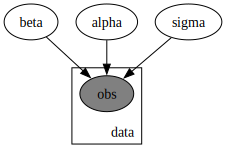

In [13]:
import torch
import numpy as np

# Function to generate example data for beta-normal regression
def generate_beta_normal_data(n_samples, n_predictors, noise_std=0.1):
    # Random coefficients and intercept
    true_beta = torch.randn(n_predictors)
    true_alpha = torch.randn(1)

    # Generate predictors
    x = torch.randn(n_samples, n_predictors)

    # Linear combination plus noise
    linear_comb = true_alpha + torch.matmul(x, true_beta)
    
    # Sigmoid transformation to map to unit interval
    mu = torch.sigmoid(linear_comb)

    # Add noise
    sigma = noise_std * torch.ones_like(mu)

    # Generate outcomes from a Beta distribution
    y = torch.distributions.Beta(mu * sigma, (1 - mu) * sigma).sample()

    return x, y, true_beta, true_alpha

# Generate example data
n_samples = 100
n_predictors = 3
x, y, true_beta, true_alpha = generate_beta_normal_data(n_samples, n_predictors)

x.shape, y.shape, true_beta, true_alpha

pyro.render_model(beta_normal_regression_model, model_args=(x, y,))